# Transfer Learning com Yolo e Detecção de objetos

> Atenção: este notebook foi desenhado para funcionar no **Google Colab**. Se pretende executar localmente prefira a versão local deste notebook, sem o sufixo ```-colab```.

Este conteúdo extra visa cobrir os seguintes tópicos:

* Transfer leraning com Yolo
* Transformadas de Hough para detecção de objetos
* Descritores de imagens

In [2]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os

#Exibição na mesma tela do Jupyter
%matplotlib inline

plt.style.use('seaborn')
sns.set_style("whitegrid", {'axes.grid' : False})

## 1. Requerimentos

Utilize o comando ao lado para instalar pelo Anaconda terminal.

* OpenCV 3.4.3 (```conda install -c conda-forge opencv==3.4.3```)
* Matplotlib 3.1.3 (```conda install matplotlib==3.1.3```)
* Seaborn 0.0.10 (```conda install -c conda-forge seaborn==0.10.0```)
* Numpy 1.18.1 (```conda install numpy==1.15.2```)

### 1.2 Arquivos

Baixe o repositório do GitHub utilizando o comando abaixo. Em caso de atualização, utilize o comando para apagar o diretório antes.

In [ ]:
!rm -rf fiap-ml-visao-computacional/

In [ ]:
!git clone https://github.com/michelpf/fiap-ml-visao-computacional

Vamos agora posicionar o diretório do repositório para a aula respectiva. Nesse caso envie o comando de mudança de diretório.

In [ ]:
%cd fiap-ml-visao-computacional/extra/

## 2. Transfer Learning com Yolo

Iremos utilizar o classificador Yolo em conjunto com o OpenCV para lidar com inferências estática de imagens e vídeos.

Alguns exemplos foram adaptados deste [artigo](https://www.pyimagesearch.com/2018/11/12/yolo-object-detection-with-opencv/) de Adrian Rosebrock.

### 2.1 Conjunto de dados

As imagens para serem treinadas em modelos do tipo Yolo precisam estar no mesmo formato que o modelo está apto a treinar. No geral as imagens podem ser redimensionadas em tempo de treinamento pois a equipe que mantém o modelo criou um utilitário para realizar esta tarefa.

A única exceção é o formato do arquivo de anotações que precisa conter a identificação da classe, centralização do objeto na imagem e seu comprimento e altura.

Para esta atividade vamos utilizar um dataset de placas de trânsito disponível no [Kaggle](https://www.kaggle.com/valentynsichkar/traffic-signs-dataset-in-yolo-format), ele foi construída pelo pesquisador Valentyn Sichkar. 

Algumas instruções de exibição das anotações foram realizadas a partir deste [notebook](https://www.kaggle.com/rblcoder/traffic-signs-images-with-bounding-boxes-in-yolo) do Kaggle.

In [43]:
arquivo_anotacao = open("imagens/00834.txt")
anotacao = arquivo_anotacao.read().strip().split(' ')
anotacao

['0', '0.8518382352941176', '0.368125', '0.04191176470588235', '0.07625']

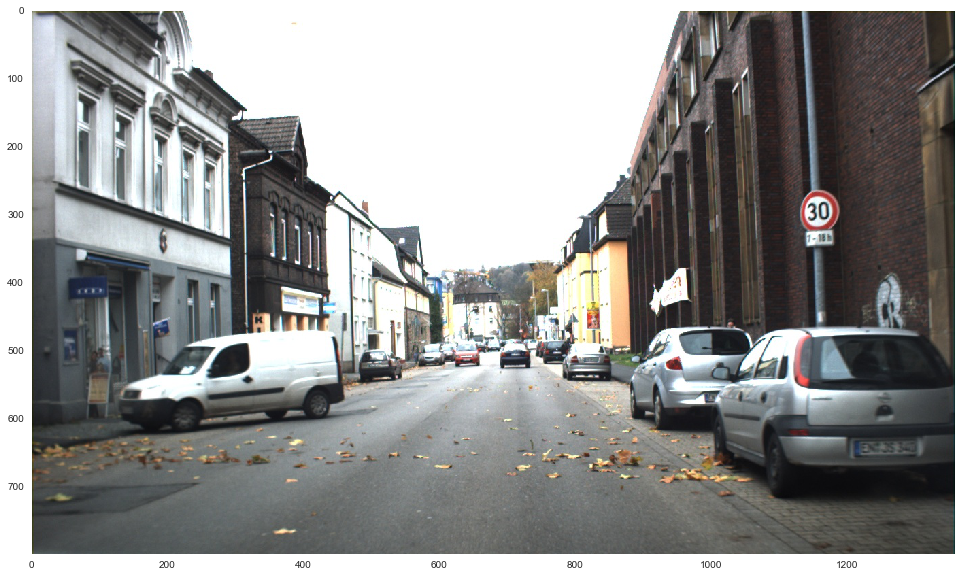

In [44]:
imagem = cv2.imread("imagens/00834.jpg")
imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(20,10))
plt.imshow(imagem)

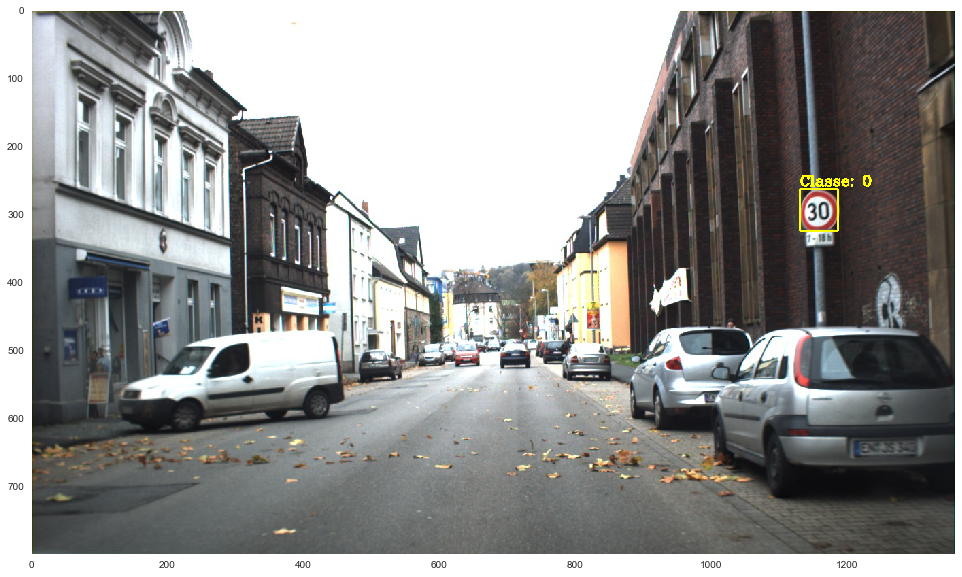

In [45]:
h, w = imagem.shape[:2]

# Getting current bounding box coordinates, its width and height
x_center, y_center = int(float(anotacao[1]) * w), int(float(anotacao[2]) * h)
box_width, box_height = int(float(anotacao[3]) * w), int(float(anotacao[4]) * h)

# Now, from YOLO data format, we can get top left corner coordinates
# that are x_min and y_min
x_min = int(x_center - (box_width / 2))
y_min = int(y_center - (box_height / 2))

# Drawing bounding box on the original image
cv2.rectangle(imagem, (x_min, y_min), (x_min + box_width, y_min + box_height), (255 , 255, 0), 2)

# Preparing text with label and confidence for current bounding box
class_current = 'Classe: {}'.format(anotacao[0])

# Putting text with label and confidence on the original image
cv2.putText(imagem, class_current, (x_min, y_min - 5), cv2.FONT_HERSHEY_COMPLEX, 0.7, (255 , 255, 0), 2)

plt.figure(figsize=(20,10))
plt.imshow(imagem)

Baixar conjunto de dados.

In [ ]:
!gdown --id 1d9rILjuEs-MSwtIdAC1XBkyeIeVYGiYV

Descompactar, sobreescrevendo conteudos se existentes.

In [ ]:
!unzip -o ts-dataset.zip

### 2.2 Configurando o utilitário Darknet

O treinamento pelo utilitário original, Darknet, é mais fácil de ser realizado em ambiente Linux. No caso de Windows precisará ser compilado para este sistema operacional, neste [guia](https://medium.com/analytics-vidhya/installing-darknet-on-windows-462d84840e5a) há instruções de como realizar este proesso. 

Há também a possibilidade de portar o modelo para ser treinado no Keras.

Para usar o utilitário, primeiro precisamos baixar o fonte e compilar.

In [ ]:
!git clone https://github.com/pjreddie/darknet
!cd darknet
!make

Após isso precisamos realizar algumas configurações para ajustar o modelo customizado, dentre eles:

1. Número de classes
2. Número de filtros (associado ao número de classes)
3. Caminho dos arquivos de treino e de teste
4. Caminho onde o modelo será gerado

O treinamento em si é bastante demorado para máquinas razoáveis. É recomendado utilizar serviços de cloud como [Paperspace](https://www.paperspace.com/).

**Passo 1**: revisar o arquivo ```ts_data.data``` e editar os caminhos do seu ambiente.

**Passo 2**: revisar os arquivos ```train.txt``` e ```test.txt``` e editar os caminhos do seu ambiente.

**Passo 3**: utilizar o arquivo de configuração de treinamento ```yolov3_ts_train.cfg``` ou obter um arquivo novo da pasta ```darknet```, obtida no passo anterior, e realizar as seguintes modificações ([fonte](https://manivannan-ai.medium.com/how-to-train-yolov3-to-detect-custom-objects-ccbcafeb13d2)).

1. Linha 6: utilize inicialmente ```batch=32```, se houver algum problema de memória diminua para a metade. Isso implica que cada etapa de treinamento será considerada um lote de 32 imagens.
2. Linha 7: utilize ```subdivisions=16```, se houver algum problema de execução considere aumentar este valor. As subdivisões são para diminuir a carga de processamento, quanto maior mais lento porém menos impacto no CPU.
3. Linha 20: utilize o máximo de batches sendo igual a 2000 por classe, logo teremos ```max_batches = 8000```.
4. Linha 22: utiliza os steps como sendo 80% e 90% do valor máximo de batches. Assim será ```steps=6400,7200```.
5. Linha 603: utilize filters = (número de classes + 5) * 3, neste caso filters = (4+5)*3 logo ```filters=27```. Os filtros se relacionam ao número de classes. Ou seja, cada classe possui 5 componentes comprimento, altura, x, y e confiança. Como cada célula de identificação podem detectar até 3 classes, por isso é realizada a multiplicação ([fonte](https://stackoverflow.com/questions/60427903/why-is-the-filters-set-as-classes-5-3-in-this-article))
6. Linha 610: utilize ```classes=4```
7. Linha 689: utilize ```filters=27``` (mesmo que Linha 7)
8. Linha 696: utilize ```classes=4```
9. Linha 776: utilize ```filters=27``` (mesmo que Linha 7)
10. Linha 783: utilize ```classes=4```

In [48]:
import os
current_dir = os.path.dirname(os.path.abspath('.'))

current_dir

'/Users/michel.fernandes/Google Drive/EY/Projetos/Python/fiap-ml-visao-computacional'

### 2.3 Realizando o treinamento

Por padrão, os treinamentos utilizando o Darknet salvam os pesos a cada 100 épocas, e com isso é possível acompanhando a evolução do modelo como também continuar de onde parou caso haja algum problema na execução na máquina. Os arquivos de backup e pesos parciais ficam na pasta ```backup```.

No arquivo de configurações, o valor máximo de épocas pode ser configurado, sendo uma medida de referência o número de batches * subdivisões, no nosso caso esse valor pode ser atribuído em 512 ou deixar usar outra heurística baseado no número de classes * 2000 iterações, que no nosso caso seria 8000 e controlar a execução com testes periódicos dos modelos e observar o valor associado ao erro.

Considere para efeitos práticos mais do que 200 épocas (ou iterações e acompanhe os valores de erro absoluto e médio, eles devem ficar no menor valor possível). O erro tende a cair bastante a partir da iteração 400.

Exemplo de execução:

Para o treinamento convergir mais rápido, vamos usar a inicialização dos pesos do seguinte modelo.

In [ ]:
!wget http://pjreddie.com/media/files/darknet53.conv.74

Com isso, podemos executar nosso treinamento. Certifique-se que esteja no diretório ```darknet``` e envie o comando:

In [ ]:
!./darknet detector train ../ts-dataset/ts_data.data ../ts-dataset/yolov3_ts_train.cfg darknet53.conv.74

````
136: 137.434723, 290.291718 avg, 0.000000 rate, 1348.793849 seconds, 4352 images
Loaded: 0.000687 seconds
Region 82 Avg IOU: nan, Class: nan, Obj: nan, No Obj: 0.316330, .5R: nan, .75R: nan,  count: 0
Region 94 Avg IOU: nan, Class: nan, Obj: nan, No Obj: 0.154690, .5R: nan, .75R: nan,  count: 0
Region 106 Avg IOU: 0.215094, Class: 0.443786, Obj: 0.210124, No Obj: 0.074126, .5R: 0.000000, .75R: 0.000000,  count: 6
Region 82 Avg IOU: nan, Class: nan, Obj: nan, No Obj: 0.314361, .5R: nan, .75R: nan,  count: 0
Region 94 Avg IOU: nan, Class: nan, Obj: nan, No Obj: 0.155542, .5R: nan, .75R: nan,  count: 0
Region 106 Avg IOU: 0.081475, Class: 0.771991, Obj: 0.114377, No Obj: 0.079347, .5R: 0.000000, .75R: 0.000000,  count: 4
Region 82 Avg IOU: nan, Class: nan, Obj: nan, No Obj: 0.317083, .5R: nan, .75R: nan,  count: 0
Region 94 Avg IOU: nan, Class: nan, Obj: nan, No Obj: 0.157591, .5R: nan, .75R: nan,  count: 0
Region 106 Avg IOU: 0.188120, Class: 0.633991, Obj: 0.079831, No Obj: 0.077979, .5R: 0.000000, .75R: 0.000000,  ...
````

O valor 136 se refere ao número da interação (epoch), seguido pelo erro, erro médio, taxa de aprendizado, tempo de execução e quantidade de imagens.

### 2.4 Realizando predições

Carregando as informações do modelo Yolo, que são: os labels, provenientes de um conjunto de dados fornecido pelo Coco, os pesos, que é o classificador já treinado, pronto para uso e um arquivo final de configurações.

Baixar pesos já treinados (400 épocas).

In [ ]:
!gdown --id 1uBC0HG00AleDS1PInqDnQg1zQIR5TPsl

Descompactar e sobreescrever se existerem conteúdos.

In [ ]:
!unzip -o yolov3_ts.zip

In [ ]:
%cd ..

In [ ]:
%cd fiap-ml-visao-computacional/extra

In [75]:
# Carregar os labels do conjunto de dados Coco
label_path = "yolo-util/classes.names"
labels = open(label_path).read().strip().split("\n")

# Atribuir a cada label uma cor diferente (randômica)
np.random.seed(42)
cores = np.random.randint(0, 255, size=(len(labels), 3), dtype="uint8")

# Definir caminho dos arquivos de pesos e configuração
pesos_path = "/content/yolov3_ts.weights"
config_path = "yolo-util/yolov3_ts_train.cfg"

# Carregar a rede
net = cv2.dnn.readNetFromDarknet(config_path, pesos_path)

Classificadores SSD (Single Shot Detection) possuem dois tipos de calibração básico. O primeiro é o limiar de confiança, quanto maior este limiar menor será o número de objetos identificados, pois ficará mais restrito aos objetos somente com maior confiança. O segundo, o NMS (Non-Maxima Supression), ou supressão não máxima, que é um parâmetro para controlar a sensibilidade em imagens com baixa luminosidade.

In [143]:
conf_threshold = 0.5
nms_threshold = 0.5

A função a seguir irá identificar os objetos em uma imagem (ou frame) e desenhar os *bounding boxes* nela, retornando a mesma imagem.

In [144]:
def identificar_objetos(frame):
    
    (H, W) = frame.shape[:2]

    ln = net.getLayerNames()
    ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]

    # Normalizando a imagem (fator de escala, tamanho, RGB/BGR)
    blob = cv2.dnn.blobFromImage(frame, 1 / 255.0, (416, 416),  swapRB=True, crop=False)
    net.setInput(blob)
    layerOutputs = net.forward(ln)

    # Inicialização das bounding boxes
    boxes = []
    confidences = []
    classIDs = []

    for output in layerOutputs:
        for detection in output:
            # Extração de pontuação e confiança
            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]

            # Filtrar somente o que for maior que o limiar de confiança
            if confidence > conf_threshold:
                
                # Definição do bounding box encontrado

                box = detection[0:4] * np.array([W, H, W, H])
                (centerX, centerY, width, height) = box.astype("int")

                x = int(centerX - (width / 2))
                y = int(centerY - (height / 2))

                boxes.append([x, y, int(width), int(height)])
                confidences.append(float(confidence))
                classIDs.append(classID)

    # Aplicação do NMS (Non-Maxima Suppression) para eliminar overlapping de bounding boxes
    
    idxs = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)

    if len(idxs) > 0:
        for i in idxs.flatten():
            # Após o filtro por NMS, desenhar os bounding boxes
            (x, y) = (boxes[i][0], boxes[i][1])
            (w, h) = (boxes[i][2], boxes[i][3])

            color = [int(c) for c in cores[classIDs[i]]]
            cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
            text = "{}: {:.4f}".format(labels[classIDs[i]], confidences[i])
            cv2.putText(frame, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
            
    return frame

Vamos fazer rum teste com uma imagem estática.

In [145]:
imagem_inferencia = cv2.imread("imagens/sign-test.jpg")
imagem_inferencia = cv2.cvtColor(imagem_inferencia, cv2.COLOR_BGR2RGB)
(width, height) = imagem_inferencia.shape[:2]

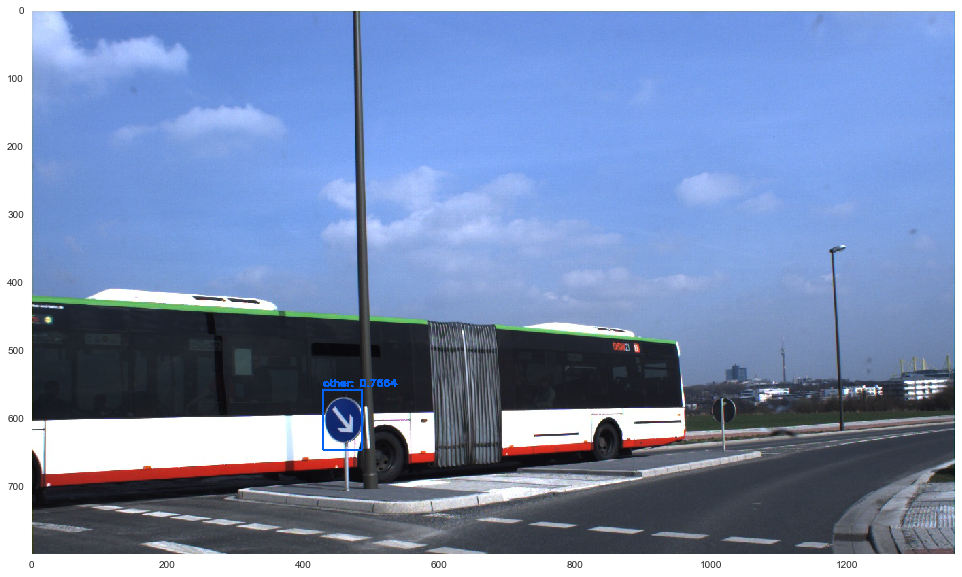

In [146]:
imagem = identificar_objetos(imagem_inferencia)

plt.figure(figsize=(20,10))
plt.imshow(imagem)

O classificador também funciona com vídeos. Há duas formas de trabalharmos. A primeira é gravarmos um vídeo e processar posteriormente um novo vídeo. A segunda, é classificar em tempo real os objetos, mas neste caso se perdem muitos frames pois o CPU não é capaz de classificar adequadamente em tempo real.

### 2.5 Analisando vídeos

Utilizando a mesma função de imagens estáticas, podemos aplicar em análises em vídeo quadro-a-quadro. 

In [98]:
cam = cv2.VideoCapture("videos/traffic-sign-to-test.mp4")
writer = None
try:
    while(True):
        
        is_capturing, imagem = cam.read()
        
        if is_capturing:
            
            frame = identificar_objetos(imagem)
           
            if writer is None:
                # initialize our video writer
                fourcc = cv2.VideoWriter_fourcc(*"MJPG")
                writer = cv2.VideoWriter("resultado.avi", fourcc, 30, (frame.shape[1], frame.shape[0]), True)

            # write the output frame to disk
            writer.write(frame)
           
        else:
            break
        
except KeyboardInterrupt:
    cam.release()
    print("Interrompido")

## 3. Transformadas de Hough

As transformadas de Hough permitem utilizar alguns métodos específicos para deteçcão de linhas e círculos, apoiando a identificação de regiões de interesse.

Utilizado imagens e trechos de código do [LearnOpenCV](https://github.com/spmallick/learnopencv/blob/master/Hough-Transform/), Satya Mallick.

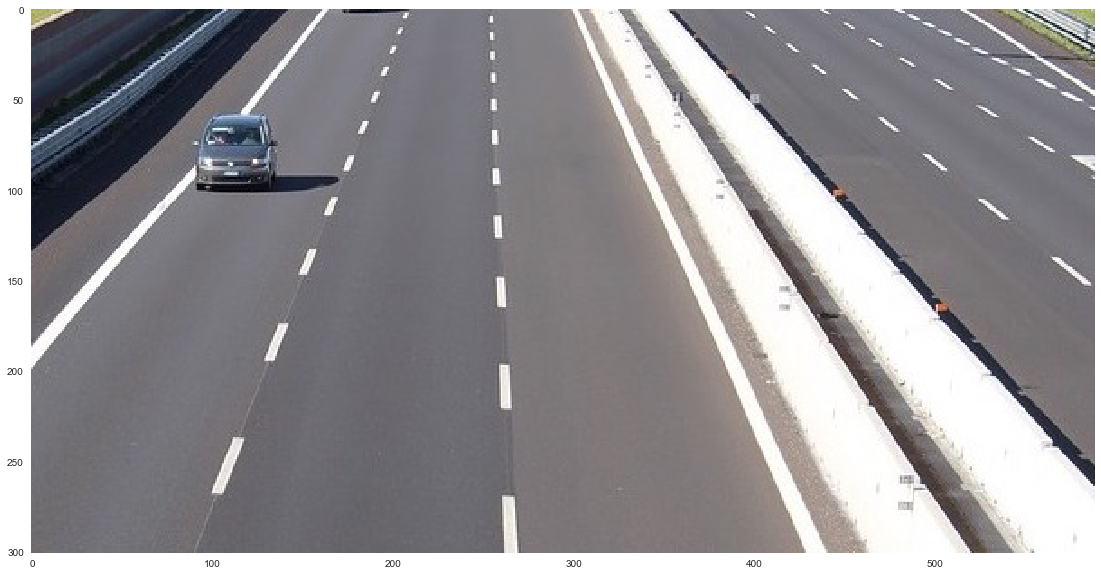

In [3]:
imagem = cv2.imread("imagens/lanes.jpeg")
imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(20,10))
plt.imshow(imagem)

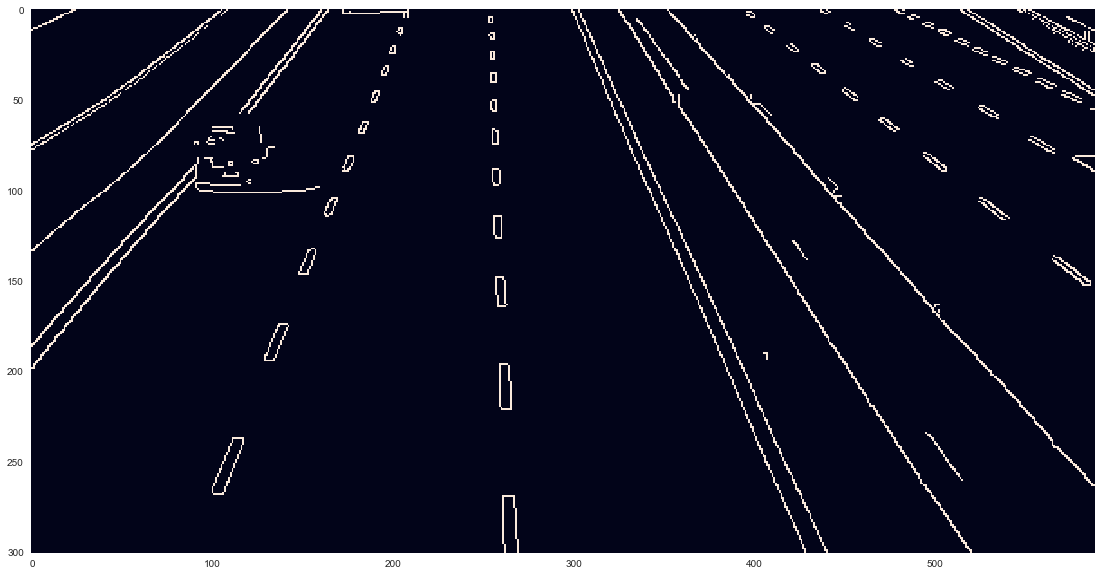

In [163]:
imagem_gray = cv2.cvtColor(imagem,cv2.COLOR_BGR2GRAY)
imagem_bordas = cv2.Canny(imagem_gray, 400, 600)

plt.figure(figsize=(20,10))
plt.imshow(imagem_bordas, cmap="gray)

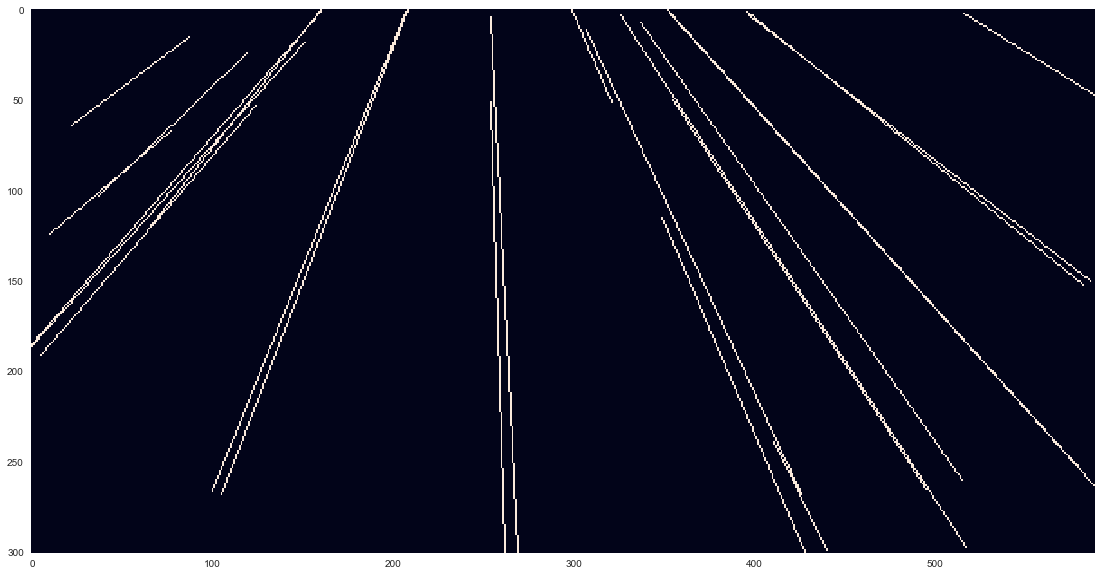

In [171]:
imagem_destacada = np.zeros(imagem.shape[:2], np.uint8)

linhas = cv2.HoughLinesP(imagem_bordas, 2, np.pi/180, 90, minLineLength=10, maxLineGap=100)

for linha in linhas:
    for x1,y1,x2,y2 in linha:
        cv2.line(imagem_destacada,(x1,y1),(x2,y2),(255,0,0),1)

plt.figure(figsize=(20,10))
plt.imshow(imagem_destacada)

In [186]:
print(linhas)

[[[326   3 517 297]]

 [[353   2 588 263]]

 [[349 115 428 300]]

 [[  0 186 151  18]]

 [[307  11 426 268]]

 [[  5 191 124  53]]

 [[  0 185 160   1]]

 [[355  50 495 265]]

 [[ 37 103 119  24]]

 [[ 22  64  87  15]]

 [[397   3 586 150]]

 [[352   0 583 257]]

 [[254   4 269 300]]

 [[ 10 124  77  67]]

 [[100 266 207   1]]

 [[254  51 262 300]]

 [[411 239 440 299]]

 [[337   7 515 260]]

 [[396   1 582 152]]

 [[299   0 321  51]]

 [[516   2 588  47]]

 [[105 268 208   0]]

 [[ 64 122 160   0]]]


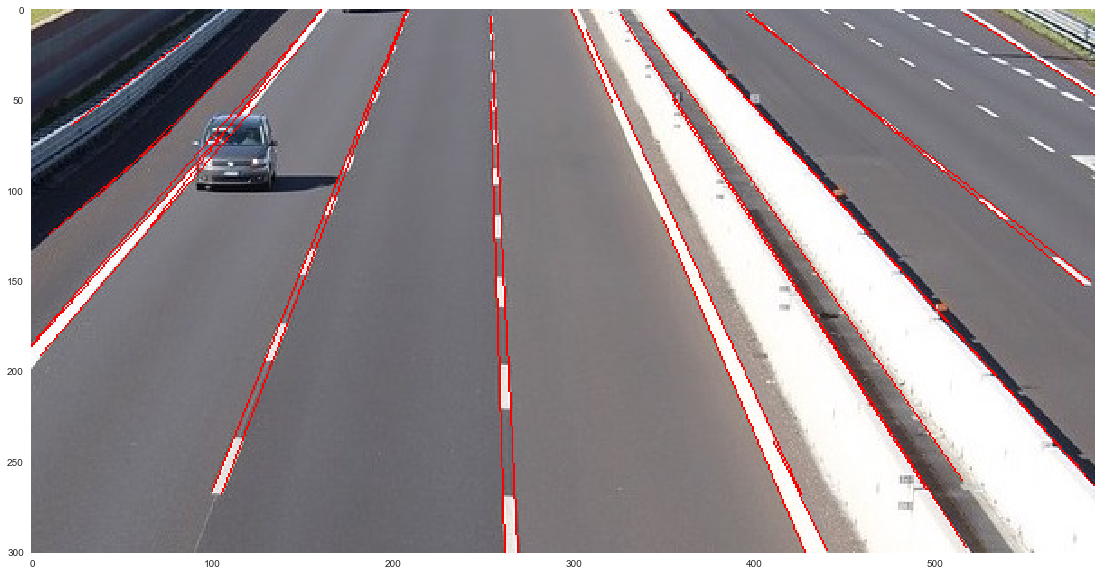

In [170]:
imagem_detectada = imagem.copy()

linhas = cv2.HoughLinesP(imagem_bordas, 2, np.pi/180, 90, minLineLength=10, maxLineGap=100)

for linha in linhas:
    for x1,y1,x2,y2 in linha:
        cv2.line(imagem_detectada,(x1,y1),(x2,y2),(255,0,0),1)

plt.figure(figsize=(20,10))
plt.imshow(imagem_detectada)

A detecção de círculas segue o mesmo princípio, porém adaptando o detector para encontrar padrões de círculos.

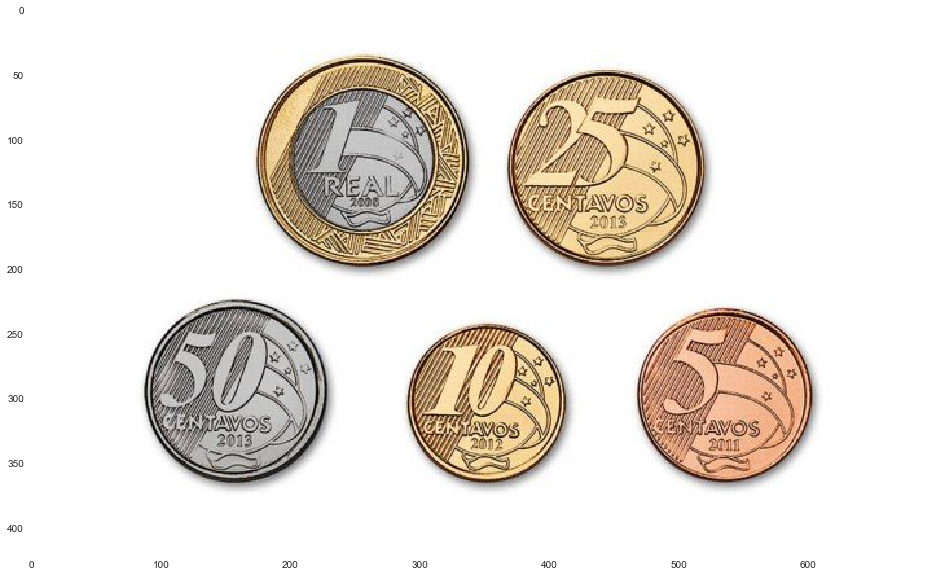

In [175]:
imagem = cv2.imread("imagens/moedas.jpeg")
imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(20,10))
plt.imshow(imagem)

[[[256.2      118.200005  80.240005]
  [443.40002  121.8       70.16    ]
  [156.6      297.        68.36    ]
  [535.80005  297.        67.76    ]
  [352.2      306.6       58.88    ]]]


Text(0.5, 1.0, 'Moedas')

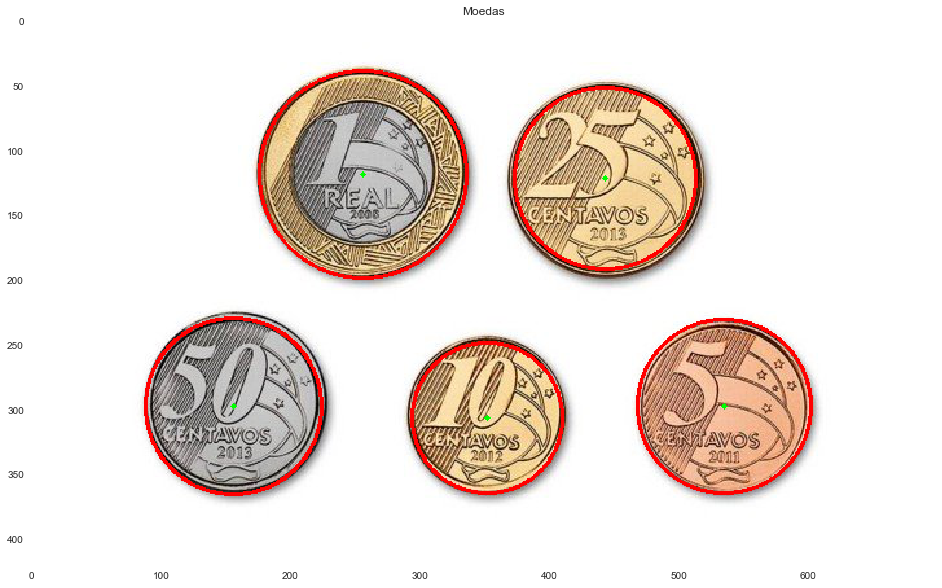

In [184]:
imagem_detectada = imagem.copy()

imagem_gray = cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY)
circulos = cv2.HoughCircles(imagem_gray, cv2.HOUGH_GRADIENT, 1.2, 70, minRadius=50, maxRadius=100)

print(circulos)

for i in circulos[0,:]:
    #Círculo em volta da moeda
    cv2.circle(imagem_detectada,(i[0], i[1]), int(i[2]), (255, 0, 0), 2) 
    #Círculo no centro da moeda
    cv2.circle(imagem_detectada, (i[0], i[1]), 2, (0, 255, 0), -1)

plt.figure(figsize=(20,10))
plt.imshow(imagem_detectada)
plt.title("Moedas")

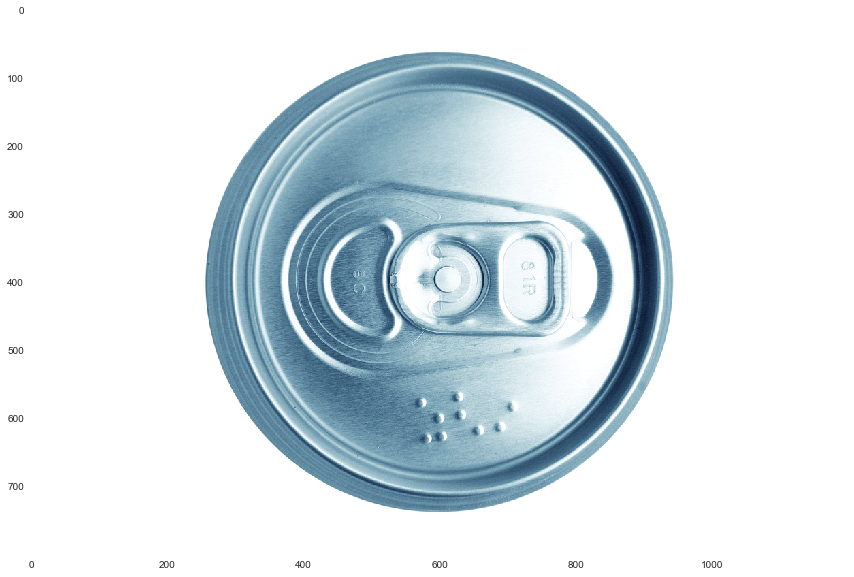

In [188]:
imagem = cv2.imread("imagens/soda_can.jpeg")
imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(20,10))
plt.imshow(imagem)

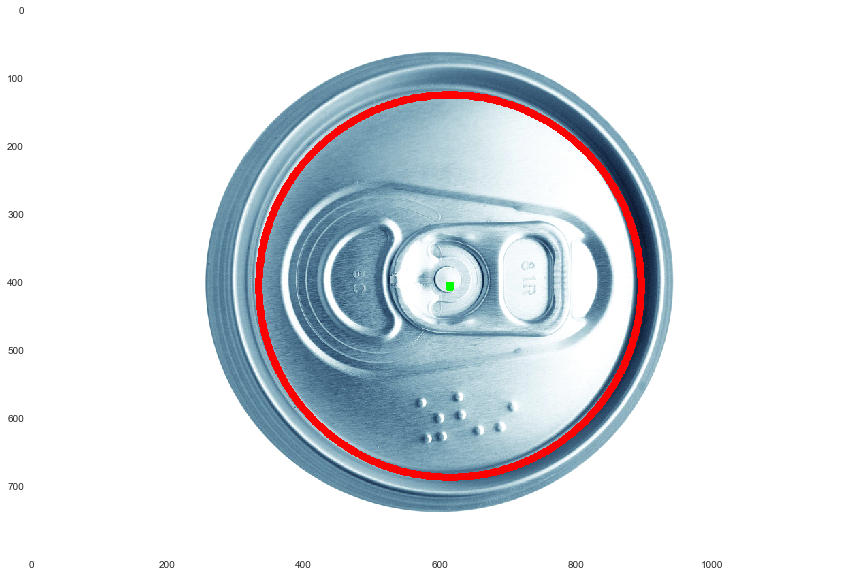

In [191]:
imagem_detectada = imagem.copy()

imagem_gray = cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY)

circles = cv2.HoughCircles(imagem_gray, cv2.HOUGH_GRADIENT, 30, 1500, minRadius=200, maxRadius=300)
 
for i in circles[0,:]:
    #Círculo em volta da moeda
    cv2.circle(imagem_detectada,(i[0], i[1]), int(i[2]), (255, 0, 0), 10) 
    #Círculo no centro da moeda
    cv2.circle(imagem_detectada, (i[0], i[1]), 2, (0, 255, 0), 10)

plt.figure(figsize=(20,10))
plt.imshow(imagem_detectada)

## 4. Descritores de imagem

Os descritores de imagem obtem referências mais relevantes que melhor o descrevem. Em geral buscam por regiões de imagem com gradientes, inclusive obtendo orietações a partir das direções dos gradientes.

Existem diversos descritores de imagem, o mais utilizado por combinar as melhores características é o ORB (Oriented FAST and Rotated BRIEF), que combina as ténicas FAST (Features from Accelerated Segment Test) e BRIEF (Binary Robust Independent Elementary Features).

O algoritmo FAST foca em rapidez, obtem os pontos chave mas sem incorporar sua orientação.

Por sua vez, o algoritmo BRIEF se encarrega em lidar com questões de escala e rotação, de tal forma que é possível comparar caraceterísticas de uma imagem em uma outra imagem, ainda que se tenha distorções de escala (imagem maior ou menor) ou rotação (inclinação).

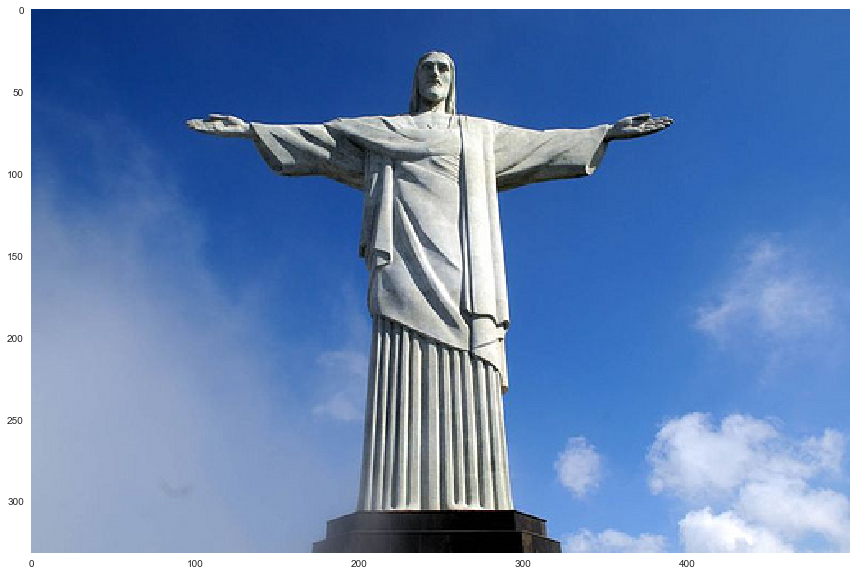

In [218]:
imagem = cv2.imread("imagens/cristo.jpeg")
imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(20,10))
plt.imshow(imagem)

In [219]:
imagem_gray = cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY)

# Para identificar todos os pontos, exclua o número do construtor abaixo
orb_detector = cv2.ORB_create()
kps_detector = orb_detector.detect(imagem_gray, None)
kps, desc = orb_detector.compute(imagem_gray, kps_detector)

print("Pontos detectados " + str(len(kps)))

Pontos detectados 497


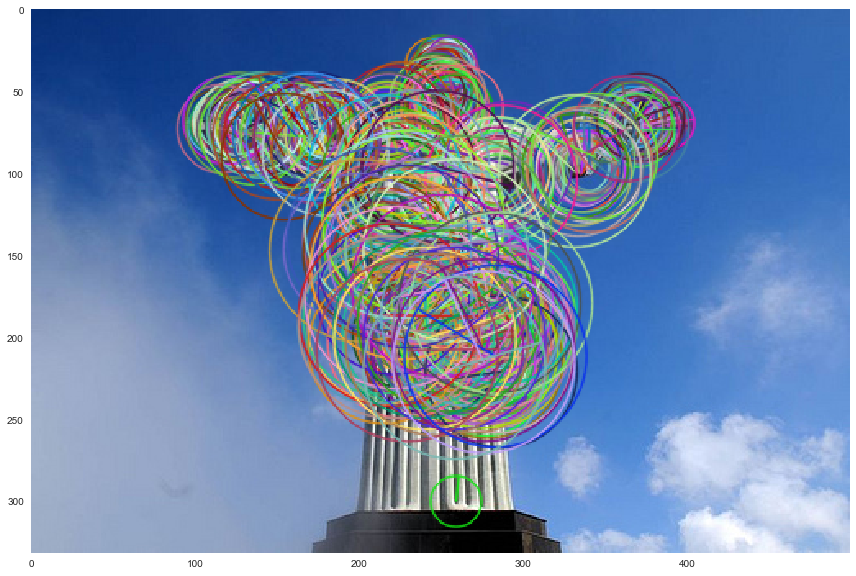

In [221]:
imagem_desc = imagem.copy()
imagem_desc = cv2.drawKeypoints(imagem_desc, kps, imagem_desc, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize=(20,10))
plt.imshow(imagem_desc)

Correspondência por FLANN

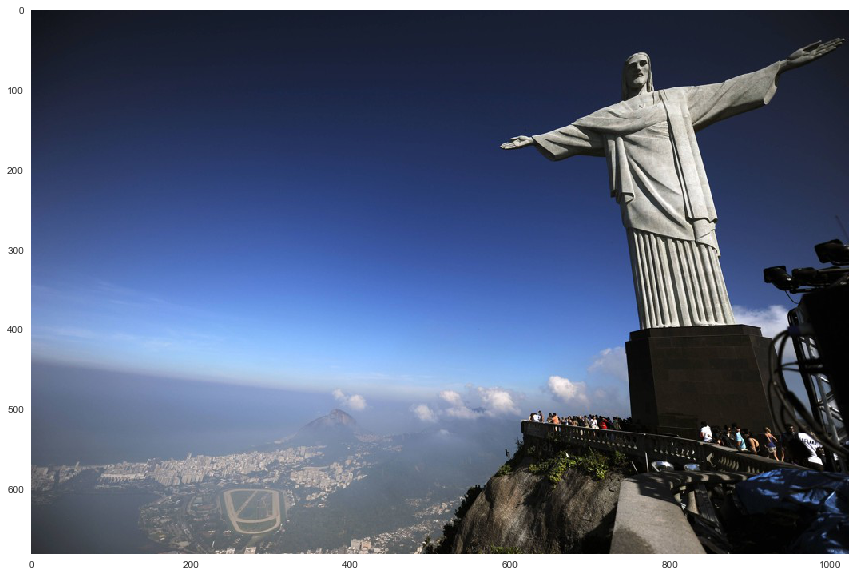

In [203]:
imagem_busca = cv2.imread("imagens/cristo-redentor.jpeg")
imagem_busca = cv2.cvtColor(imagem_busca, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(20,10))
plt.imshow(imagem_busca)

In [209]:
imagem_busca_gray = cv2.cvtColor(imagem_busca, cv2.COLOR_BGR2GRAY)

orb_detector = cv2.ORB_create()

kps_detector = orb_detector.detect(imagem_busca_gray, None)
kps_busca, desc_busca = orb_detector.compute(imagem_busca_gray, kps_detector)

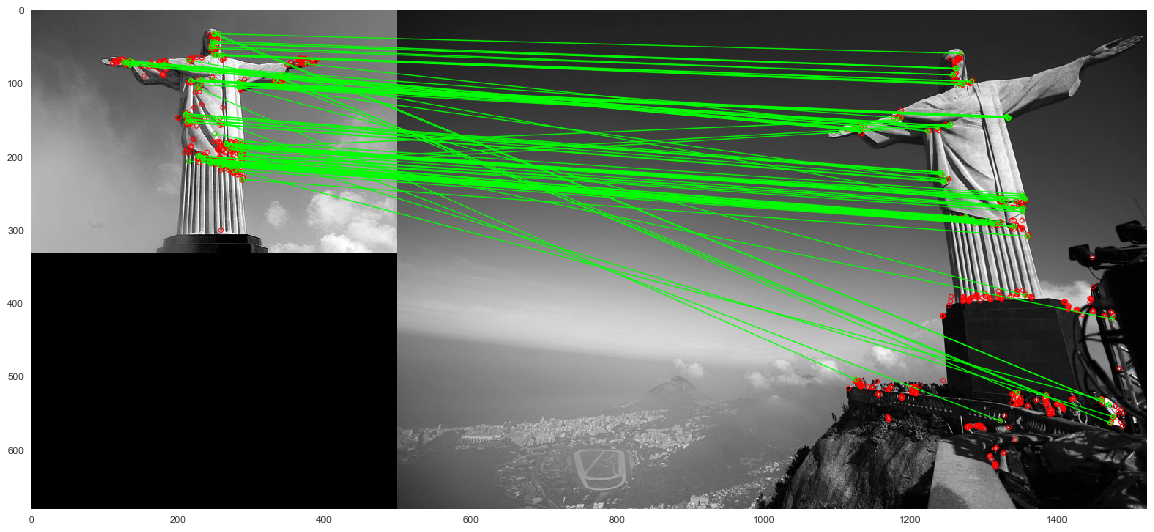

In [225]:
FLANN_INDEX_LSH = 6
index_params= dict(algorithm = FLANN_INDEX_LSH, table_number = 6, key_size = 12, multi_probe_level = 1) 

search_params = dict(checks=50)

flann = cv2.FlannBasedMatcher(index_params, search_params)

matches = flann.knnMatch(desc, desc_busca, k=2)

# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in range(len(matches))]

# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        matchesMask[i]=[1,0]
        
draw_params = dict(matchColor = (0,255,0), singlePointColor = (255,0,0), matchesMask = matchesMask, flags = 0)
imagem_detected = cv2.drawMatchesKnn(imagem_gray, kps, imagem_busca_gray, kps_busca, matches, None, **draw_params)

plt.figure(figsize=(20,10))
plt.imshow(imagem_detected)